# Getting Started With ASE

[The atomistic simulation environment](https://wiki.fysik.dtu.dk/ase/index.html) (ASE) is an extremely powerful tool for generating atomic structures and performing density functional theory calculations (DFT.) 

In [5]:
!pip install ase
!pip install nglview
!jupyter-nbextension enable nglview --py --sys-prefix  # this might be needed

     |████████████████████████████████| 4.7MB 119kB/s eta 0:00:01


  Stored in directory: /home/bencomer/.cache/pip/wheels/8c/da/f6/4566348a9f1575ebe4c37fe9aff0dd7adc33e6c587031ae77c
Successfully built nglview
Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK


## The Atoms Object
ASE allows you to manipulate atomic structures in a programitic way using the [ASE atoms object](https://wiki.fysik.dtu.dk/ase/ase/atoms.html). This is a `class` in python that can store the positions and identities of atoms in a structure and manipulate them in useful ways. This is pretty abstract, so here is an example of generating an atoms object:

In [1]:
from ase.atoms import Atoms # import the Atoms class from ASE

H2 = Atoms(symbols='HH', positions=[(0,0,0), (0,0,0.75)])
print(H2)

Atoms(symbols='H2', pbc=False)


The code above just generates an H$_2$ molecule, one hydrogen at the origin and one 0.75 angstroms up in the z direction. We can now manipulate it in interesting ways. Let's say we want to add a second H$_2$ molecule 2 angstroms away. We can do this by simply adding atoms objects to the one we already have

In [2]:
H2 = H2 + Atoms('H2', positions = [(2,0,0), (2,0,0.75)])
print(H2)
print(H2.positions)

Atoms(symbols='H4', pbc=False)
[[0.   0.   0.  ]
 [0.   0.   0.75]
 [2.   0.   0.  ]
 [2.   0.   0.75]]


So now we have have two H$_2$ molecules, we can shift all the atoms by simply adding an array to their positions

In [3]:
H2.positions = H2.positions + [0,0,1]
print(H2.positions)

[[0.   0.   1.  ]
 [0.   0.   1.75]
 [2.   0.   1.  ]
 [2.   0.   1.75]]


What does this look like though? We can visualize any structure using ASE's built in visualization tools

In [7]:
from ase.visualize import view

view(H2) # removing viewer='ngl' makes a pop-up window

Atoms objects are also able to be indexed like lists. Each individual atom has an index and can be accessed in this way. When you call an index of an atoms object, you get an `Atom` object. This is just an object that represents a single atom. `Atoms` objects are simply a collection of `Atom` objects

In [8]:
print(H2[0])
print(H2[0].position)
print(H2[0].symbol)

Atom('H', [0.0, 0.0, 1.0], index=0)
[0. 0. 1.]
H


Since we're doing periodic calculations, we want to put these atoms into a unit cell (a simulation box) to do this we want to use the `set_cell` method. Let's use a 10 angstrom box. We also want to write this to a file. ASE atoms objects have a `write` method that allows you to write to [almost any file type you can imagine](https://wiki.fysik.dtu.dk/ase/ase/io/io.html) (including .png images).

In [9]:
H2.set_cell([10,10,10])
H2.center() # this centers it in the unit cell
print(H2.cell)

Cell([10.0, 10.0, 10.0], pbc=False)


In [10]:
view(H2)

We can also write and read files using ASE

In [11]:
H2.write('2_hydrogens.xyz')

from ase.io import read # for reading files

H2_2 = read('2_hydrogens.xyz')

There are lots of useful things you can do to manipulate atoms, they are all documentated in the [ASE atoms object documentation](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).

But having to have all the positions for the atoms in an atoms object is quite onerous. Luckily, there are [tools to build structures in ASE](https://wiki.fysik.dtu.dk/ase/ase/build/build.html). For example, there is a molecule function that holds the positions of lots of common molecules. Similarly, the `bulk` function contains tons of bulk structures for metals. We'll use this to generate surfaces a little later on

In [16]:
from ase.build import molecule, bulk
#from ase.data.pubchem import pubchem_atoms_search

water = molecule('H2O')
print(water)
print(water.positions)
view(water)

iron = bulk('Fe', cubic = True)
view(iron)

Atoms(symbols='OH2', pbc=False)
[[ 0.        0.        0.119262]
 [ 0.        0.763239 -0.477047]
 [ 0.       -0.763239 -0.477047]]


# ASE Calculators

ASE has the ability to attach a "calculator" to an atoms object. At a fundamental level, these are just classes that will return energies and forces. That means it can be a DFT program, a quantum chemistry program, or even just a classical potential like "Leonard-Jones" There are [a ton](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html) of calculators implmented. Here we will just use a simple one, the [EMT](https://wiki.fysik.dtu.dk/ase/ase/calculators/emt.html) calculator.

The `EMT` calculator is just a simple pair potential calculator for a few metals. In practice it is a toy calculator used for testing.

You start by making an instance of your calculator, then using `set_calculator` to attach it to an atoms object. Once that is done you can call `get_potential_energy` and `get_forces` to calculate the energy and forces.

<img src="6-12_potential.gif">

In [17]:
from ase.calculators.emt import EMT

calc = EMT()
water.set_calculator(calc)
energy = water.get_potential_energy()
forces = water.get_forces()

print(energy)
print(forces)

2.619811483369738
[[ 0.          0.          7.73836531]
 [ 0.          5.14779422 -3.86918266]
 [ 0.         -5.14779422 -3.86918266]]


In our group we use quatum espresso, VASP, and Abinit to do DFT in general.

A primary use of calculators is to perform structural optimizations. This allows us to find the "lowest energy configuration" of a given structure. ASE has [tools](https://wiki.fysik.dtu.dk/ase/ase/optimize.html) to do this. Below we're using the `BFGSLineSearch` optimization method

In [18]:
from ase.optimize import BFGSLineSearch

relax = BFGSLineSearch(atoms = water)
relax.run(fmax = 0.05) # relax the structure until the maximum force is 0.05 eV/A

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:34:46        2.619811*       7.7384
BFGSLineSearch:    1[  2] 10:34:46        1.879326*       0.0443


True

In [19]:
view(water)

### Exercise:

Use the EMT calculator to plot the potential energy as a function of distance between two H atoms.

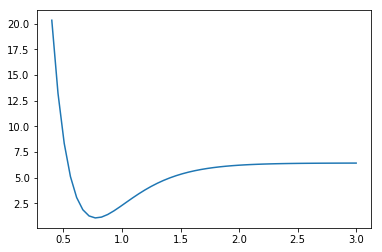

In [39]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
rs = np.linspace(0.4, 3, 50)
engs = []
## calculate energy as a function of r
for r in rs:
    atoms = molecule('H2')
    atoms.set_distance(0,1,r)
    atoms.set_calculator(EMT())
    engs.append(atoms.get_potential_energy())
    
plt.plot(rs, engs)


# Calculating Reaction Energies

Reaction energies are the core of computational catalysis and surface science because they provide fundamental information about the energy for a chemical reaction. This section is meant to cover the basics of how to calculate a reaction energy using DFT.

The adsorption energy is defined as the energy difference between the combined system and the separate systems:

$E_{rxn} = \Sigma E_{products} - \Sigma E_{reactants}$

here we're going to calculate the reaction energy of forming water for O$_2$ and H$_2$

We'll start by making an O$_2$ molecule

In [28]:
from ase.build import molecule

O2 = molecule('O2')

lets visualize it next.

In [29]:
from ase.visualize import view

view(O2)

To calculate the energy of this molecule, we're going to use the EMT calculator.

In [30]:
from ase.calculators.emt import EMT

O2.set_calculator(EMT())

Next we need to optimize the structure, because chances are it's not in its lowest energy configuration

In [31]:
from ase.optimize import QuasiNewton

dyn = QuasiNewton(O2)
dyn.run(fmax=0.05)


E_O2 = O2.get_potential_energy()

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:42:47        0.922681*       3.7034
BFGSLineSearch:    1[  2] 10:42:47        0.629226*       0.5399
BFGSLineSearch:    2[  3] 10:42:47        0.625298*       0.1946
BFGSLineSearch:    3[  4] 10:42:47        0.624750*       0.0064


next let's build and optimize H$_2$ and H$_2$O. ASE has some nice tools for doing this.

In [32]:
H2 = molecule('H2')


H2.set_calculator(EMT())
dyn = QuasiNewton(H2)
dyn.run(fmax=0.05)

E_H2 = H2.get_potential_energy()


                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:43:04        1.158863*       4.4619
BFGSLineSearch:    1[  2] 10:43:04        1.076999*       1.0416
BFGSLineSearch:    2[  3] 10:43:04        1.070713*       0.1746
BFGSLineSearch:    3[  4] 10:43:04        1.070542*       0.0090


In [33]:
view(H2)

Now we add the adsorpate and optimize That.

In [34]:
H2O = molecule('H2O')


H2O.set_calculator(EMT())
dyn = QuasiNewton(H2O)
dyn.run(fmax=0.05)

E_H2O = H2O.get_potential_energy()


                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:43:34        2.619811*       7.7384
BFGSLineSearch:    1[  2] 10:43:34        1.879326*       0.0443


In [35]:
view(H2O)

Now, finally, we have the energy of the gas, the slab, and the slab with the adsorbate. We can now calculate the adsorption energy.

In [36]:
E_rxn = E_H2O - E_H2 - 0.5*E_O2
print(E_rxn) # answer is in eV

0.49640892802334635


Note that this is not very accurate! The real value is approximately -285.8261 kJ/mol. The reason is that we used the "EMT" calculator, which is not appropriate for the physics of molecules. However, it is very fast, so it allows us to see the principles behind how reaction energies can be computed. If we want accurate numbers, we need to use quantum mechanics, approximated through Density Functional Theory (DFT). This will be much more computationally expensive, and will require a supercomputer. You will learn more about this in future lessons.

In [37]:
from ase.units import kJ, mol
true_value = -285.8261 * kJ / mol
print(true_value)

-2.962378751888467


In [38]:
error = (E_rxn-true_value)/true_value
print(error)

-1.1675710533998713
